In [52]:
import pandas as pd
import numpy as np
import os
import sys

sys.path.append('/'.join(os.getcwd().split('/')[:-2]))


In [53]:
import config 
CONTEXT_INERTIA = 5#  conf.CONEXT_INERTIA
DB= config.DB
CONTEXT_DIMENSION = 128


if DB == 'MONGO':
    from src.utilities.graph_operations.mongodb import touch_connection_db, find_word, update_graph_context
if DB == 'REDIS':
    from src.utilities.graph_operations.redis import touch_connection_db, find_word, update_graph_context


In [54]:
print(config.DB)

REDIS


In [55]:


def get_input_context(text):
    running_context = np.zeros(CONTEXT_DIMENSION)
    words = text.split(' ')
    connections = get_ngram(words,2)
    for connection in connections:
        connection_properties = touch_connection_db(connection[0],connection[1])
        if connection_properties['update_count'] == 0:
            print('connection is not trained,' ,connection)
        running_context += connection_properties['context'] /CONTEXT_INERTIA
        running_context = running_context / np.linalg.norm(running_context)
        
    return running_context, connection[1]
    
    
    

def get_node_activations(word,running_context,breadth):
   
    word_connections = find_word(word)
    
    if len(word_connections) >0 :

        breadth = min(len(word_connections),breadth)
        words, activation_socre, connection_context =  get_context_agreement(word_connections,running_context)
       
        #get index of max n 
        active_index = np.argpartition(activation_socre,-breadth)[-breadth:]
        activation_socre   = [ activation_socre[i] for i in active_index]
        connections        = [ words[i] for i in active_index]
        connection_context = [ connection_context[i] for i in active_index]

        return activation_socre,connection_context,connections 

    else :
        print('graph has no connections for the word {}'.format(word))
        return [] , [] ,[]
    
def get_branch_activations(text,breadth,depth) :
    
    running_context, origin = get_input_context(text)
    # [['word'] ,score, running_context,  , depth]
    response =  [[[origin] , 0 ,running_context, 0]]
    output   = []
    while len(response) > 0 : 
        if response[0][3] < depth:
            shifted_origin = response[0][0][-1]
            shited_context = response[0][2]
            activation_score,connection_context ,connections = get_node_activations(shifted_origin,shited_context,breadth)
            p_node = response[0].copy()
            response.pop(0)
            for index, connection in enumerate(connections):
                branch  = p_node[0] + [connection]
                context = connection_context[index]
                score   = p_node[1] + activation_score[index]
                level   = p_node[3] + 1
                response.append([branch , score,context ,level])
        else :
            response[0][0].pop(0)
            output.append(response[0][:-2])
            response.pop(0)
    #print(output)
    return output



def get_context_agreement(word_connections,running_context):
    words = []
    activation_socre =[]
    connection_context =[]
    for connection in word_connections :
        context  = connection['context']
        activation_socre.append(np.dot(running_context,context))
        words.append(connection['connection'])
        connection_context.append(enrich_context(running_context,context))
        
    return words, activation_socre, connection_context
        

def enrich_context(running_context,connection_context):
    
    enriched_context_vector  = running_context + connection_context *CONTEXT_INERTIA
    
    return enriched_context_vector / np.linalg.norm(enriched_context_vector)


def get_ngram(indices, window_size=2):
    ngrams = []
    count = 0
    for token in indices[:len(indices)-window_size+1]:
        ngrams.append(indices[count:count+window_size])
        count = count+1
    return ngrams


In [56]:
text= 'with the assistance of local'

In [57]:
depth =  1
breadth = 10
#text = "the eyes don't see what the mind doesn't know"
ouutput = get_branch_activations(text,breadth,depth)

In [58]:
output_df = pd.DataFrame(ouutput).sort_values(by=1,ascending=False)
output_df.tail(10)[0].values

array([list(['concerts']), list(['tv']), list(['woman']), list(['bay']),
       list(['council']), list(['arabic']), list(['economic']),
       list(['united']), list(['baltic']), list(['reaction'])],
      dtype=object)

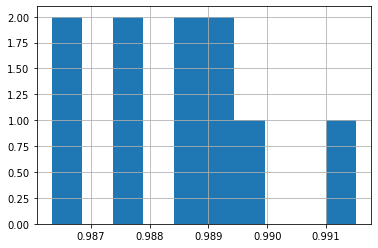

In [59]:
ax = output_df[1].hist()

In [60]:
depth =  5
breadth = 2
#text = "the eyes don't see what the mind doesn't know"
ouutput = get_branch_activations(text,breadth,depth)

In [61]:
output_df = pd.DataFrame(ouutput).sort_values(by=1,ascending=False)
output_df.tail(10)[0].values

array([list(['concerts', 'and', 'ambassador', 'to', 'the']),
       list(['concerts', 'and', 'ambassador', 'to', 'be']),
       list(['concerts', 'he', 'made', 'post', 'but']),
       list(['concerts', 'he', 'made', 'post', 'is']),
       list(['concerts', 'and', 'musical', 'play', 'the']),
       list(['concerts', 'and', 'musical', 'play', 'over']),
       list(['concerts', 'and', 'ambassador', 'for', 'the']),
       list(['concerts', 'and', 'ambassador', 'for', 'many']),
       list(['concerts', 'and', 'musical', 'plays', 'outside']),
       list(['concerts', 'and', 'musical', 'plays', 'to'])], dtype=object)

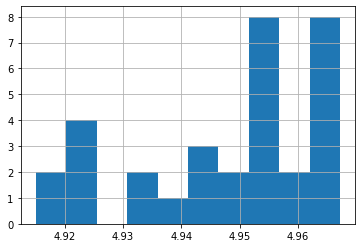

In [51]:
ax = output_df[1].hist()